# 1. Introduction
A census is the procedure of systematically acquiring and recording information about the members of a given population.
The census is a special, wide-range activity, which takes place once a decade in the entire country. The purpose is to gather information about the general population, in order to present a full and reliable picture of the population in the country - its housing conditions and demographic, social and economic characteristics. The information collected includes data on age, gender, country of origin, marital status, housing conditions, marriage, education, employment, etc.

## 1.1  Data description
This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics).  The prediction task is to determine whether a person makes over $50K a year.

## 1.2 Features Description
**1. Categorical Attributes**
 * **workclass**:  Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
  -  Individual work category  
 * **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
  -  Individual's highest education degree  
 * **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
  -  Individual marital status  
 * **occupation**:  Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
  -  Individual's occupation  
 * **relationship**:  Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
  -  Individual's relation in a family   
 * **race**:  White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
  -  Race of Individual   
 * **sex**:  Female, Male.
 * **native-country**:  United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
  -  Individual's native country   
  
**2. Continuous Attributes**
 * **age**: continuous.
  -  Age of an individual  
 * **fnlwgt**: final weight, continuous. 
 * The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US.  These are prepared monthly for us by Population Division here at the Census Bureau.
 * **capital-gain**: continuous.
 * **capital-loss**: continuous.
 * **hours-per-week**: continuous.
  -  Individual's working hour per week   

## 1.3 Objective of this project
The goal of this machine learning project is to predict whether a person makes over 50K a year or not given their demographic variation. This is a classification problem.

# 2. Import packages

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn import metrics
from datetime import datetime
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold

## Load Data

In [ ]:
data = pd.read_csv("../input/adult.csv")
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
data.shape

(48842, 15)

# 3. Data Cleaning

Fixing the common nan values

    Nan values were as ? in data. Hence we fix this with most frequent element(mode) in the entire dataset. It generalizes well, as we will see with the accuracy of our classifiers

In [ ]:
attrib, counts = np.unique(data['workclass'], return_counts = True)
most_freq_attrib = attrib[np.argmax(counts, axis = 0)]
data['workclass'][data['workclass'] == '?'] = most_freq_attrib 

attrib, counts = np.unique(data['occupation'], return_counts = True)
most_freq_attrib = attrib[np.argmax(counts, axis = 0)]
data['occupation'][data['occupation'] == '?'] = most_freq_attrib 

attrib, counts = np.unique(data['native-country'], return_counts = True)
most_freq_attrib = attrib[np.argmax(counts, axis = 0)]
data['native-country'][data['native-country'] == '?'] = most_freq_attrib 

Lets look the data it again :

In [ ]:
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,Private,103497,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States,<=50K


# 4. Feature Engineering

Education

    9th, 10th, 11th, 12th comes under HighSchool Grad but it has mentioned separately
    Create Elementary object for 1st-4th, 5th-6th, 7th-8th

Marital Status

    
    Married-civ-spouse,Married-spouse-absent,Married-AF-spouse comes under category Married
    Divorced, separated again comes under category separated.

Workclass

    Self-emp-not-inc, Self-emp-inc comes under category self employed
    Local-gov,State-gov,Federal-gov comes under category goverment emloyees


In [ ]:
hs_grad = ['HS-grad','11th','10th','9th','12th']
elementary = ['1st-4th','5th-6th','7th-8th']

# replace elements in list.
data['education'].replace(to_replace = hs_grad,value = 'HS-grad',inplace = True)
data['education'].replace(to_replace = elementary,value = 'elementary_school',inplace = True)

data['education'].value_counts()

HS-grad              20398
Some-college         10878
Bachelors             8025
Masters               2657
Assoc-voc             2061
elementary_school     1711
Assoc-acdm            1601
Prof-school            834
Doctorate              594
Preschool               83
Name: education, dtype: int64

In [ ]:
married= ['Married-spouse-absent','Married-civ-spouse','Married-AF-spouse']
separated = ['Separated','Divorced']

#replace elements in list.
data['marital-status'].replace(to_replace = married ,value = 'Married',inplace = True)
data['marital-status'].replace(to_replace = separated,value = 'Separated',inplace = True)

data['marital-status'].value_counts()

Married          23044
Never-married    16117
Separated         8163
Widowed           1518
Name: marital-status, dtype: int64

In [ ]:
self_employed = ['Self-emp-not-inc','Self-emp-inc']
govt_employees = ['Local-gov','State-gov','Federal-gov']

#replace elements in list.
data['workclass'].replace(to_replace = self_employed ,value = 'Self_employed',inplace = True)
data['workclass'].replace(to_replace = govt_employees,value = 'Govt_employees',inplace = True)

data['workclass'].value_counts()

Private           36705
Govt_employees     6549
Self_employed      5557
Without-pay          21
Never-worked         10
Name: workclass, dtype: int64

### Deleting the unuseful features and observations

In [ ]:
del_cols = ['relationship','educational-num']
data.drop(labels = del_cols,axis = 1,inplace = True)

In [ ]:
# drop rows with age 90
print("Number of observation before removing:",data.shape)
index_age = data[data['age'] == 90].index
data.drop(labels = index_age,axis = 0,inplace =True)
print("Number of observation after removing:",data.shape)

Number of observation before removing: (48842, 13)
Number of observation after removing: (48787, 13)


In [ ]:
print("Number of observation before removing:",data.shape)
index_gain = data[data['capital-gain'] == 99999].index
data.drop(labels = index_gain,axis = 0,inplace =True)
print("Number of observation after removing:",data.shape)

Number of observation before removing: (48787, 13)
Number of observation after removing: (48543, 13)


### Updating the columns

In [ ]:
num_col_new = ['age','capital-gain', 'capital-loss',
       'hours-per-week','fnlwgt']
cat_col_new = ['workclass', 'education', 'marital-status', 'occupation',
               'race', 'gender', 'income']

# 5. Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(data[num_col_new]),columns = num_col_new).head(5)

,age,capital-gain,capital-loss,hours-per-week,fnlwgt
0,0.111111,0.000000,0.0,0.397959,0.145129
1,0.291667,0.000000,0.0,0.500000,0.052451
2,0.152778,0.000000,0.0,0.397959,0.219649
3,0.375000,0.186105,0.0,0.397959,0.100153
4,0.013889,0.000000,0.0,0.295918,0.061708


In [ ]:
class DataFrameSelector(TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
                
    def fit(self,X,y = None):
        return self
    
    def transform(self,X):
        return X[self.attribute_names]
    
    
class num_trans(TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        df = pd.DataFrame(X)
        df.columns = num_col_new 
        return df
        
    
    
pipeline = Pipeline([('selector',DataFrameSelector(num_col_new)),  
                     ('scaler',MinMaxScaler()),
                    ('transform',num_trans())])

In [ ]:
num_df = pipeline.fit_transform(data)
num_df.shape

(48543, 5)

In [ ]:
# columns which I don't need after creating dummy variables dataframe
cols = ['workclass_Govt_employess','education_Some-college',
        'marital-status_Never-married','occupation_Other-service',
        'race_Black','gender_Male','income_>50K']

In [ ]:
class dummies(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols
    
    def fit(self,X,y = None):
        return self
    
    def transform(self,X):
        df = pd.get_dummies(X)
        df_new = df[df.columns.difference(cols)] 
#difference returns the original columns, with the columns passed as argument removed.
        return df_new

pipeline_cat=Pipeline([('selector',DataFrameSelector(cat_col_new)),
                      ('dummies',dummies(cols))])
cat_df = pipeline_cat.fit_transform(data)
cat_df.shape

(48543, 36)

In [ ]:
cat_df['id'] = pd.Series(range(cat_df.shape[0]))
num_df['id'] = pd.Series(range(num_df.shape[0]))

In [ ]:
final_df = pd.merge(cat_df,num_df,how = 'inner', on = 'id')
print(f"Number of observations in final dataset: {final_df.shape}")

Number of observations in final dataset: (48247, 42)


## 5.2 Split the dataset¶

In [ ]:
y = final_df['income_<=50K']
final_df.drop(labels = ['id','income_<=50K','fnlwgt'],axis = 1,inplace = True)
X = final_df

## 5.3 Take a look to Income class distribution

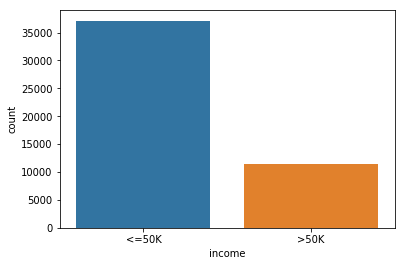

<=50K    37113
>50K     11430
Name: income, dtype: int64

In [ ]:
sns.countplot(x="income", data= data)
plt.show()
data["income"].value_counts()

## 5.4 Resampling

The main idea of sampling classes is to either increasing the samples of the minority class or decreasing the samples of the majority class. This is done in order to obtain a fair balance in the number of instances for both the classes.

There can be two main types of sampling:

    You can add copies of instances from the minority class which is called over-sampling (or more formally sampling with replacement), or
    You can delete instances from the majority class, which is called under-sampling.


A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

**Under-sampling**

Advantages of this approach:

    It can help improve the runtime of the model and solve the memory problems by reducing the number of training data samples when the training data set is enormous.


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X, y)

Using TensorFlow backend.


In [ ]:
X_rus = pd.DataFrame(X_rus)
X_rus.columns = ['education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Preschool', 'education_Prof-school',
       'education_elementary_school', 'gender_Female',
       'marital-status_Married', 'marital-status_Separated',
       'marital-status_Widowed', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Other',
       'race_White', 'workclass_Govt_employees', 'workclass_Never-worked',
       'workclass_Private', 'workclass_Self_employed', 'workclass_Without-pay',
       'age', 'capital-gain', 'capital-loss', 'hours-per-week']
y_rus = pd.DataFrame(y_rus)
y_rus.columns = ["income"]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_rus,y_rus,test_size =0.25,random_state = 42)

In [ ]:
X_train.shape

(17050, 39)

## 5.5 Baseline models

In [ ]:
# Spot-Check Algorithms
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))

    
    return basedModels

In [ ]:
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 3
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=10)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names,results

In [ ]:
class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [ ]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)

LR: 0.781935 (0.005025)
LDA: 0.782581 (0.003783)
KNN: 0.751085 (0.002466)
CART: 0.700704 (0.003381)
NB: 0.553783 (0.005690)
AB: 0.777595 (0.003813)
GBM: 0.778710 (0.002562)
RF: 0.742581 (0.000642)
ET: 0.731027 (0.008458)


In [ ]:
py.init_notebook_mode(connected=True)
PlotBoxR().PlotResult(names,results)

## 5.6 Models Scores

In [ ]:
def ScoreDataFrame(names,results):
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame
basedLineScore = ScoreDataFrame(names,results)
basedLineScore.sort_values(by='Score', ascending=False)

,Model,Score
1,LDA,0.7826
0,LR,0.7819
6,GBM,0.7787
5,AB,0.7776
2,KNN,0.7511
7,RF,0.7426
8,ET,0.7310
3,CART,0.7007
4,NB,0.5538


# 6. Tuning Machine Learning Models

## 6.1 Logistic Regression

**Logistic Regression is used when the dependent variable(target) is categorical.**

**Model**

Output = 0 or 1

Hypothesis => Z = WX + B

hΘ(x) = sigmoid (Z)

**Sigmoid Function**
![logistic.png](attachment:logistic.png)

If ‘Z’ goes to infinity, Y(predicted) will become 1 and if ‘Z’ goes to negative infinity, Y(predicted) will become 0.

**Cost Function**
![sfd.png](attachment:sfd.png)

## Hyperparameter Tuning 
A hyperparameter is a parameter whose value is set before the learning process begins.
Tuning Strategies

We will explore two different methods for optimizing hyperparameters:

    Grid Search
    Random Search

### Grid Search vs Random search

**Grid search** is a traditional way to perform hyperparameter optimization. It works by searching exhaustively through a specified subset of hyperparameters.

**Random search** differs from grid search mainly in that it searches the specified subset of hyperparameters randomly instead of exhaustively. The major benefit being decreased processing time.

* There is a tradeoff to decreased processing time, however. We aren’t guaranteed to find the optimal combination of hyperparameters.

![HPO1.png](attachment:HPO1.png)

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(class_weight='balanced',random_state=42)
param_grid = { 
    'C': [0.1,0.2,0.3,0.4],
    'penalty': ['l1', 'l2'],
    'class_weight':[{0: 1, 1: 1},{ 0:0.67, 1:0.33 },{ 0:0.75, 1:0.25 },{ 0:0.8, 1:0.2 }]}
CV_rfc = GridSearchCV(estimator=lr, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'C': 0.4, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l1'}

**C : Inverse of regularization strength**

we use paramter C as our regularization parameter. Parameter C = 1/λ.

Lambda (λ) controls the trade-off between allowing the model to increase it's complexity as much as it wants with trying to keep it simple. For example, if λ is very low or 0, the model will have enough power to increase it's complexity (overfit) by assigning big values to the weights for each parameter. If, in the other hand, we increase the value of λ, the model will tend to underfit, as the model will become too simple.

* Parameter C will work the other way around. For small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C, we low the power of regularization which imples the model is allowed to increase it's complexity, and therefore, overfit the data.

**L2 Regularization or Ridge Regularization**

* Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function. Here the highlighted part represents L2 regularization element.
![ewr.png](attachment:ewr.png)

**L1 Regularization or Lasso**

* Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.
![tre.png](attachment:tre.png)

The key difference between these techniques is that Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features.

**Class weight**

* If we have highly imbalanced classes and have no addressed it during preprocessing, we have the option of using the class_weight parameter to weight the classes to make certain we have a balanced mix of each class. Class weights will be given by n_samples / (n_classes * np.bincount(y))

In [ ]:
#fitting the model
lr1=LogisticRegression(C=0.4, random_state=4 ,penalty='l1', class_weight={0:1,1:1})
lr1.fit(X_train,y_train)

LogisticRegression(C=0.4, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=4, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# predict 
y_pred1=lr1.predict(X_test)

### Evaluation of logistic regression(Grid Search)
**Confusion Matrix**

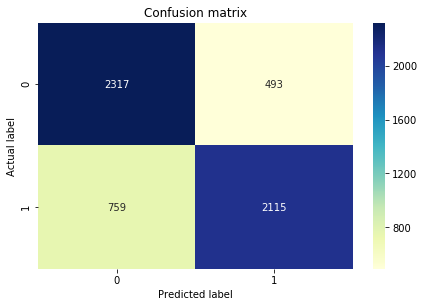

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred1)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred1))
print("Precision:",metrics.precision_score(y_test, y_pred1))
print("Recall:",metrics.recall_score(y_test, y_pred1))
print("F1 score:",metrics.f1_score(y_test, y_pred1))

Accuracy: 0.7797325826882477
Precision: 0.8109662576687117
Recall: 0.7359081419624217
F1 score: 0.7716161984677126


**Precision:**
Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct.
Precision can be thought of as a measure of a classifier's exactness.
![ret.png](attachment:ret.png)

**Recall:**
Out of all the positive classes, how much we predicted correctly. It should be high as possible.
Recall can be thought of as a measure of a classifier's completeness.
![ytu.png](attachment:ytu.png)

**F1 score**
It is difficult to compare two models with low precision and high recall or vice versa. So to make them comparable, we use F-Score.

F-score helps to measure Recall and Precision at the same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.
![uyt.png](attachment:uyt.png)

### ROC Curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

    True Positive Rate
    False Positive Rate
![gfh.png](attachment:gfh.png)

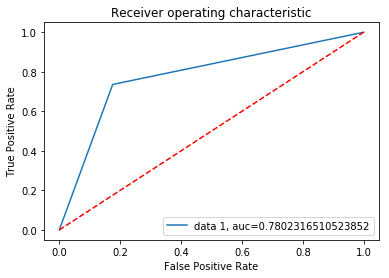

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred1)
auc = metrics.roc_auc_score(y_test, y_pred1)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

### Random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
lr = LogisticRegression(class_weight='balanced',random_state=42)
param_grid = { 
    'C': [0.1,0.2,0.3,0.4, .5],
    'penalty': ['l1', 'l2'],
    'class_weight':[{0: 1, 1: 1},{ 0:0.67, 1:0.33 },{ 0:0.75, 1:0.25 },{ 0:0.8, 1:0.2 }]}
CV_rfc = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'penalty': 'l2', 'class_weight': {0: 1, 1: 1}, 'C': 0.3}

In [ ]:
#fitting the model
lr2=LogisticRegression(C=0.4, random_state=4 ,penalty='l2', class_weight={0:1,1:1})
lr2.fit(X_train,y_train)

LogisticRegression(C=0.4, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=4, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# predict 
y_pred2=lr2.predict(X_test)


### Evaluation of logistic regression(Random Search)

#### Confusion Matrix

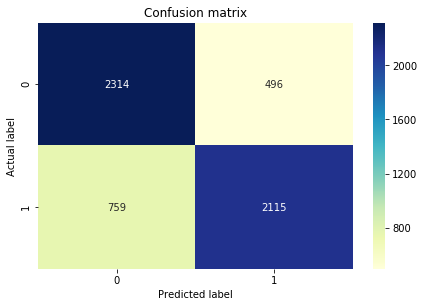

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred2)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))
print("Precision:",metrics.precision_score(y_test, y_pred2))
print("Recall:",metrics.recall_score(y_test, y_pred2))
print("F1 score:",metrics.f1_score(y_test, y_pred2))

Accuracy: 0.7792047853624209
Precision: 0.8100344695518958
Recall: 0.7359081419624217
F1 score: 0.7711941659070192


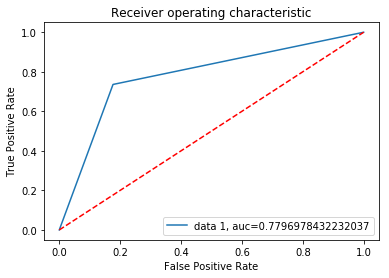

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred2)
auc = metrics.roc_auc_score(y_test, y_pred2)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

## Recursive Feature Elimination

* The Recursive Feature Elimination (or RFE) works by recursively removing attributes and building a model on those attributes that remain. 
* It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.
* As the name suggests, this method eliminates worst performing features on a particular model one after the other until the best subset of features are known.
![vnb.png](attachment:vnb.png)

In [ ]:
from sklearn.feature_selection import RFE

# feature extraction
lr = LogisticRegression()
rfe = RFE(lr, 15)
lr3 = rfe.fit(X_train, y_train)

print("Num Features: ", lr3.n_features_)
print("Selected Features: ",  lr3.support_)
print("Feature Ranking: ", lr3.ranking_)

Num Features:  15
Selected Features:  [False False  True  True False  True  True  True  True False  True  True
  True False  True False  True False False False  True False  True  True
  True False False False False False False False False False False False
 False False False]
Feature Ranking:  [15 16  1  1  8  1  1  1  1  9  1  1  1  4  1  3  1 18 25  7  1  2  1  1
  1  5 22 19  6 14 12 13 10 11 17 23 21 24 20]


**Features sorted by their rank:**

In [ ]:
feature = list(X_train.columns.values) 
print(sorted(zip(map(lambda x: round(x, 4), lr3.ranking_), feature)))

[(1, 'education_Bachelors'), (1, 'education_Doctorate'), (1, 'education_Masters'), (1, 'education_Preschool'), (1, 'education_Prof-school'), (1, 'education_elementary_school'), (1, 'marital-status_Married'), (1, 'marital-status_Separated'), (1, 'marital-status_Widowed'), (1, 'occupation_Armed-Forces'), (1, 'occupation_Exec-managerial'), (1, 'occupation_Priv-house-serv'), (1, 'occupation_Protective-serv'), (1, 'occupation_Sales'), (1, 'occupation_Tech-support'), (2, 'occupation_Prof-specialty'), (3, 'occupation_Craft-repair'), (4, 'occupation_Adm-clerical'), (5, 'occupation_Transport-moving'), (6, 'race_Other'), (7, 'occupation_Machine-op-inspct'), (8, 'education_HS-grad'), (9, 'gender_Female'), (10, 'workclass_Private'), (11, 'workclass_Self_employed'), (12, 'workclass_Govt_employees'), (13, 'workclass_Never-worked'), (14, 'race_White'), (15, 'education_Assoc-acdm'), (16, 'education_Assoc-voc'), (17, 'workclass_Without-pay'), (18, 'occupation_Farming-fishing'), (19, 'race_Asian-Pac-Isl

In [ ]:
X_train_f = X_train[['education_Bachelors','education_Doctorate','education_Masters','education_Preschool',
                     'education_Prof-school','education_elementary_school','marital-status_Married',
                     'marital-status_Separated','marital-status_Widowed','occupation_Exec-managerial',
                     'occupation_Prof-specialty','occupation_Protective-serv','occupation_Sales','occupation_Tech-support']]

X_test_f = X_test[['education_Bachelors','education_Doctorate','education_Masters','education_Preschool',
                     'education_Prof-school','education_elementary_school','marital-status_Married',
                     'marital-status_Separated','marital-status_Widowed','occupation_Exec-managerial',
                  'occupation_Prof-specialty','occupation_Protective-serv','occupation_Sales','occupation_Tech-support']]

lr4=LogisticRegression(C=0.4, random_state=4 ,penalty='l2', class_weight={0:1,1:1})
lr4.fit(X_train_f,y_train)

LogisticRegression(C=0.4, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=4, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

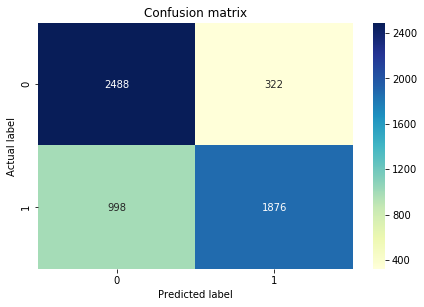

Accuracy: 0.7677691766361717
Precision: 0.8535031847133758
Recall: 0.6527487821851079
F1 score: 0.7397476340694007


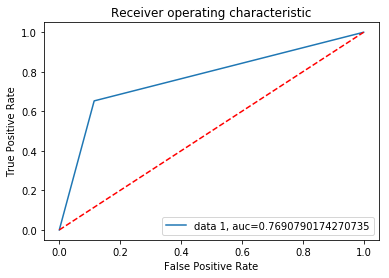

In [ ]:
# predict 
y_pred4=lr4.predict(X_test_f)
cf_matrix = confusion_matrix(y_test, y_pred4)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print("Accuracy:",metrics.accuracy_score(y_test, y_pred4))
print("Precision:",metrics.precision_score(y_test, y_pred4))
print("Recall:",metrics.recall_score(y_test, y_pred4))
print("F1 score:",metrics.f1_score(y_test, y_pred4))

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred4)
auc = metrics.roc_auc_score(y_test, y_pred4)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

## PCA analysis
Principal Component Analysis (or PCA) uses linear algebra to transform the dataset into a compressed form.

Generally this is called a data reduction technique. A property of PCA is that you can choose the number of dimensions or principal component in the transformed result.

In this case we will use it to analyse the feature importanace

<BarContainer object of 39 artists>

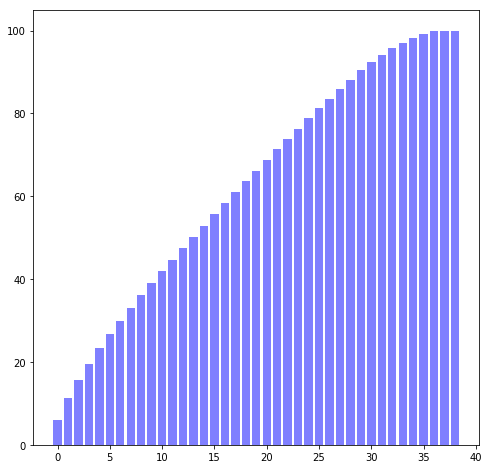

In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X_train)


from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=39)
Y_sklearn = sklearn_pca.fit_transform(X_std)

cum_sum = sklearn_pca.explained_variance_ratio_.cumsum()

sklearn_pca.explained_variance_ratio_[:10].sum()

cum_sum = cum_sum*100

fig, ax = plt.subplots(figsize=(8,8))
plt.bar(range(39), cum_sum, label='Cumulative _Sum_of_Explained _Varaince', color = 'b',alpha=0.5)

Text(0, 0.5, 'Cumulative explained variance')

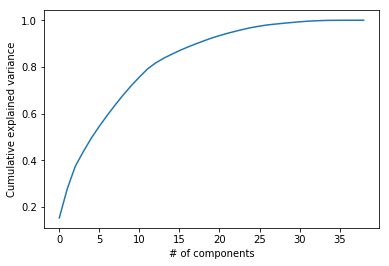

In [ ]:
#Cumulative explained variance
from sklearn.decomposition import PCA
pca = PCA(39)
pca_full = pca.fit(X)

plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('# of components')
plt.ylabel('Cumulative explained variance')

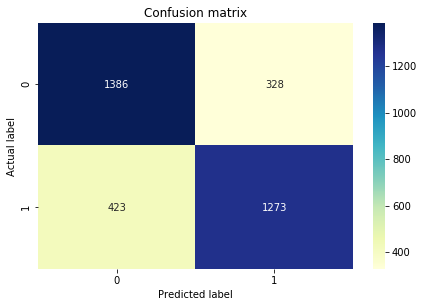

Accuracy: 0.7797653958944282
Precision: 0.7951280449718926
Recall: 0.7505896226415094
F1 score: 0.7722171671216256


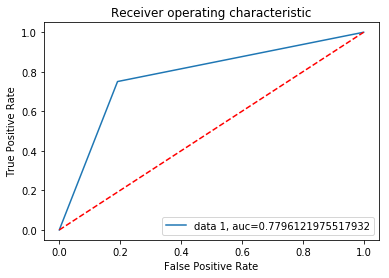

In [ ]:
# 26 Principal Components seems good 

pca = PCA(n_components=26)
X_transformed = pca.fit_transform(X_train)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split( 
    X_transformed, y_train, test_size=0.2, random_state=13)

lr5=LogisticRegression(C=0.4, random_state=4 ,penalty='l1', class_weight={0:1,1:1})
lr5.fit(X_train_pca, y_train_pca)

# predict 
y_pred =lr5.predict(X_test_pca)

cf_matrix = confusion_matrix(y_test_pca, y_pred)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print("Accuracy:",metrics.accuracy_score(y_test_pca, y_pred))
print("Precision:",metrics.precision_score(y_test_pca, y_pred))
print("Recall:",metrics.recall_score(y_test_pca, y_pred))
print("F1 score:",metrics.f1_score(y_test_pca, y_pred))

fpr, tpr, _ = metrics.roc_curve(y_test_pca,  y_pred)
auc = metrics.roc_auc_score(y_test_pca, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

# Feature Importance

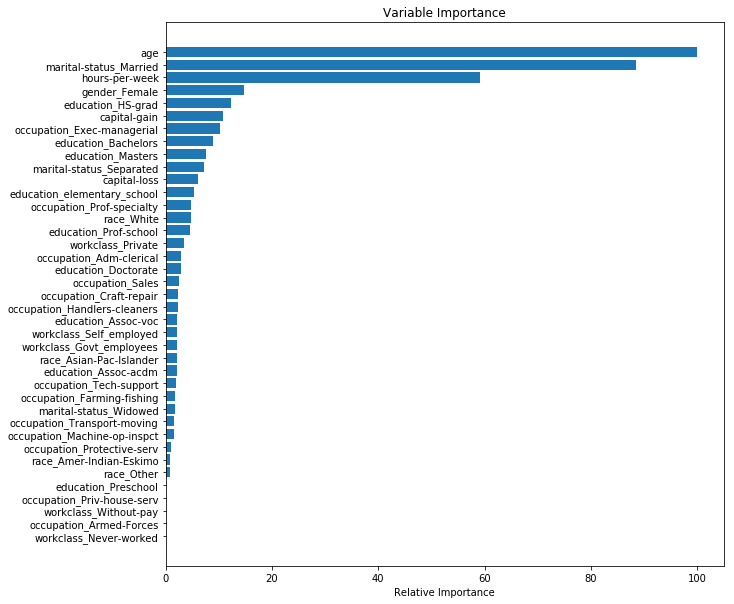

In [ ]:
data1 = pd.DataFrame(X,y)

clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=2)

clf.fit(X_train, y_train)


# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, data1.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
X_train_ef = X_train[['race_White','education_Doctorate', 'marital-status_Separated','education_elementary_school', 'occupation_Prof-specialty',
                      'education_Prof-school', 'capital-loss', 'education_Masters','education_Bachelors', 'education_HS-grad','occupation_Exec-managerial',
                    'gender_Female', 'capital-gain','marital-status_Married', 'hours-per-week', 'age']]
X_test_ef = X_test[['race_White','education_Doctorate', 'marital-status_Separated','education_elementary_school', 'occupation_Prof-specialty',
                      'education_Prof-school', 'capital-loss', 'education_Masters','education_Bachelors', 'education_HS-grad','occupation_Exec-managerial',
                    'gender_Female', 'capital-gain','marital-status_Married', 'hours-per-week', 'age']]

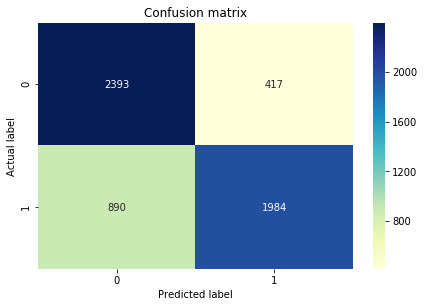

Accuracy: 0.7700562983814215
Precision: 0.8263223656809663
Recall: 0.6903270702853166
F1 score: 0.7522274881516589


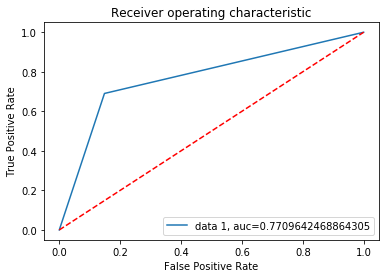

In [ ]:
lr5=LogisticRegression(C=0.4, random_state=4 ,penalty='l1', class_weight={0:1,1:1})
lr5.fit(X_train_ef, y_train)

# predict 
y_pred =lr5.predict(X_test_ef)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

### Grid Search

In [ ]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def Best_Model_Predict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

### Random Search

In [ ]:
from scipy.stats import uniform

class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def Best_Model_Predict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred

# 6.2 KNN

**kNN is non-parametric, instance based, lazy algorithm and used in the supervised setting.**

* Non-parametric :
      
      It means that algorithm has no pre assumptions about the functional form of the model, to avoid mismodeling .

* Instance based :
      
      It means that our algorithm does not explicitly learn a model.
      Instead, it memorize the training instances which are subsequently used as “knowledge” for the prediction.

* Lazy algorithm :

      It means that it does not use the training data for the Generalization i.e. these algorithm has no explicit training phase or it is minimal. Training is very fast.
      
**kNN Algorithm for Classification**

Training element {xi, yi} , Testing point(x)

    Compute the Distance D(x,xi) to every training element xi.
    Select k closest instance xi1,xi2,…….., xik and their labels yi1, yi2 …, yik.
    Output the class y* which is most frequent in yi1,yi2 ……yik.
    


**Significant of “k”**

    Value of k has strong effect on kNN performance.
    k act as controller to decide the shape of decision boundary.
    Large value of k has following properties:

 1. Smoother decision boundary
 2. It provide more voters for prediction, it implies less affect from outliers.
 3. As a result has Lower Variance and High Bias.
 
 ![gh.jpeg](attachment:gh.jpeg)
 
**How to Select k**

    The simplest solution is Cross Validation.
    Best method is to try many k values and use Cross-Validation to see which k value is giving the best result.


In [ ]:
k_range = list(range(2,15))
d_metric = ['euclidean','minkowski']

param_grid = dict(n_neighbors = k_range, metric =d_metric)

knn = KNeighborsClassifier()

KNN_GridSearch = GridSearch(X_train_f, y_train, knn ,param_grid)
y_pred = KNN_GridSearch.Best_Model_Predict(X_test_f)

Best: 0.766804 using {'metric': 'euclidean', 'n_neighbors': 14}


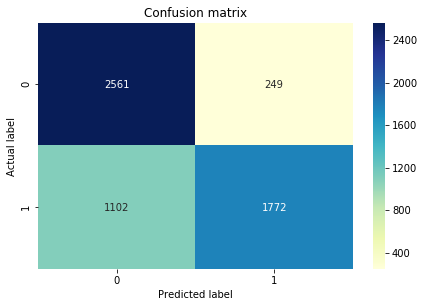

Accuracy: 0.7623152709359606
Precision: 0.8767936665017318
Recall: 0.616562282533055
F1 score: 0.7240040858018386


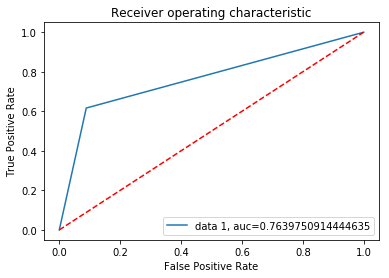

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

# 6.3 SVM (Support Vector Machine)

**What is a Support Vector Machine**
A Support Vector Machine is a supervised machine learning algorithm which can be used for both classification and regression problems. It follows a technique called the kernel trick to transform the data and based on these transformations, it finds an optimal boundary between the possible outputs.

**How does it work?**
The main idea is to identify the optimal separating hyperplane which maximizes the margin of the training data. 

The goal of SVMs is to find the optimal hyperplane because it not only classifies the existing dataset but also helps predict the class of the unseen data. And the optimal hyperplane is the one which has the biggest margin.



In [ ]:
param_grid = [{'gamma': [ 0.1, 1, 10],'C': [ 0.10, 10, 100]}]

svm = SVC()

svm_GridSearch = GridSearch(X_train_f, y_train, svm,param_grid )
y_pred = svm_GridSearch.Best_Model_Predict(X_test_f)


Best: 0.773607 using {'C': 10, 'gamma': 1}


**Kernel**

kernel parameters selects the type of hyperplane used to separate the data. Using ‘linear’ will use a linear hyperplane (a line in the case of 2D data). ‘rbf’ and ‘poly’ uses a non linear hyper-plane.

**gamma**

gamma is a parameter for non linear hyperplanes. The higher the gamma value it tries to exactly fit the training data set.  Increasing gamma leads to overfitting as the classifier tries to perfectly fit the training data.

**C**

C is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly.

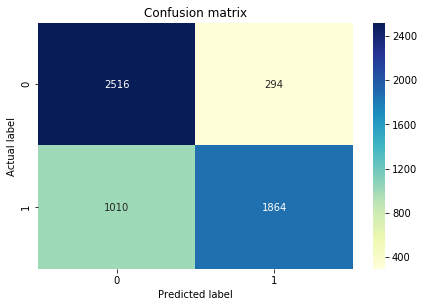

Accuracy: 0.7705840957072484
Precision: 0.8637627432808156
Recall: 0.6485734168406402
F1 score: 0.7408585055643879


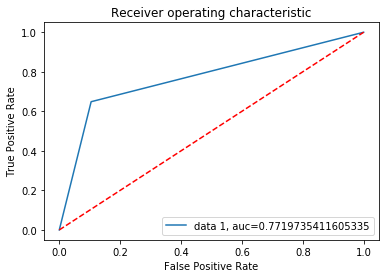

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

# 6.4 LDA

* Linear Discriminant Analysis (LDA) is most commonly used as dimensionality reduction technique in the pre-processing step for pattern-classification and machine learning applications. 
* The goal is to project a dataset onto a lower-dimensional space with good class-separability in order avoid overfitting (“curse of dimensionality”) and also reduce computational costs.

In general, dimensionality reduction does not only help reducing computational costs for a given classification task, but it can also be helpful to avoid overfitting by minimizing the error in parameter estimation (“curse of dimensionality”).

In [ ]:
param_grid = [{'n_components': [1,2,3,4]}]

lda = LinearDiscriminantAnalysis()

lda_GridSearch = GridSearch(X_train, y_train, lda , param_grid )
y_pred = lda_GridSearch.Best_Model_Predict(X_test)

Best: 0.781232 using {'n_components': 1}


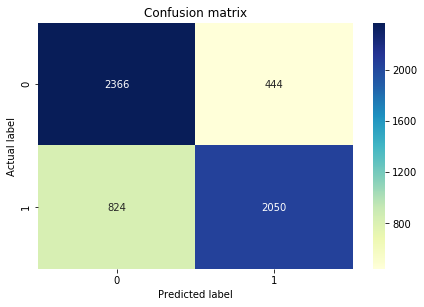

Accuracy: 0.776917663617171
Precision: 0.8219727345629511
Recall: 0.7132915796798887
F1 score: 0.7637853949329358


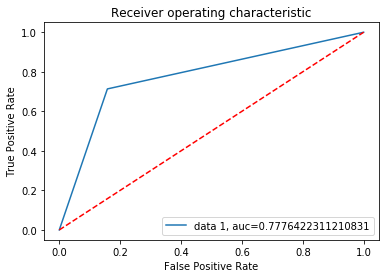

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

# 6.5 Decision Tree

**Introduction to Decision Trees**

* A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

**How does Decision Tree works ?**

* Decision tree is a type of supervised learning algorithm (having a pre-defined target variable) that is mostly used in classification problems. It works for both categorical and continuous input and output variables. In this technique, we split the population or sample into two or more homogeneous sets (or sub-populations) based on most significant splitter / differentiator in input variables.

![asdwq.png](attachment:asdwq.png)

The core algorithm for building decision trees called ID3 by J. R. Quinlan which employs a top-down, greedy search through the space of possible branches with no backtracking. ID3 uses Entropy and Information Gain to construct a decision tree. 

**The popular attribute selection measures:**

    Information gain
    Gini index


**Advantages of CART**

    Simple to understand, interpret, visualize.
    Decision trees implicitly perform variable screening or feature selection.
    Can handle both numerical and categorical data. Can also handle multi-output problems.
    Decision trees require relatively little effort from users for data preparation.
    Nonlinear relationships between parameters do not affect tree performance.
    
**Disadvantages of CART**

    Decision-tree learners can create over-complex trees that do not generalize the data well.This is called overfitting.
    Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This is called variance, which needs to be lowered by methods like bagging and boosting.

### Implemention of Decision Tree

In [ ]:
from scipy.stats import randint
max_depth_value = [4, 5,6,7,8,9,10,11,12,13]
max_features_value =  randint(1, 7)
min_samples_leaf_value = randint(1, 4)
criterion_value = ["gini", "entropy"]

param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)

CART = DecisionTreeClassifier(random_state=1)

CART_RandSearch = RandomSearch(X_train_f, y_train, CART, param_grid)
Prediction_CART = CART_RandSearch.Best_Model_Predict(X_test_f)


Best: 0.773196 using {'criterion': 'gini', 'max_depth': 13, 'max_features': 3, 'min_samples_leaf': 1}


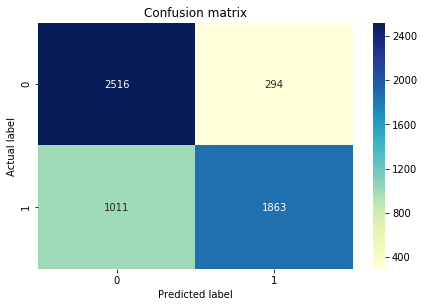

Accuracy: 0.7704081632653061
Precision: 0.8636995827538247
Recall: 0.6482254697286013
F1 score: 0.740608228980322


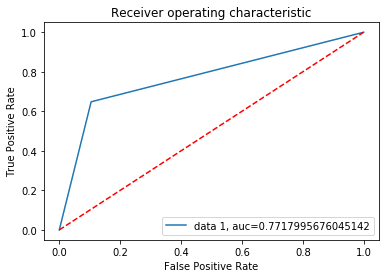

In [ ]:
cf_matrix = confusion_matrix(y_test, Prediction_CART)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print("Accuracy:",metrics.accuracy_score(y_test, Prediction_CART))
print("Precision:",metrics.precision_score(y_test, Prediction_CART))
print("Recall:",metrics.recall_score(y_test, Prediction_CART))
print("F1 score:",metrics.f1_score(y_test, Prediction_CART))

fpr, tpr, _ = metrics.roc_curve(y_test,  Prediction_CART)
auc = metrics.roc_auc_score(y_test, Prediction_CART)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

# 6.6 Ensemble methods

**What is an ensemble method?**

Ensemble is a Machine Learning concept in which the idea is to train multiple models using the same learning algorithm. The ensembles take part in a bigger group of methods, called multiclassifiers, where a set of hundreds or thousands of learners with a common objective are fused together to solve the problem.
When we try to predict the target variable using any machine learning technique, the main causes of difference in actual and predicted values are noise, variance, and bias. Ensemble helps to reduce these factors (except noise, which is irreducible error).

**Techniques to perform ensemble decision trees:**

**1. Bagging**

Bagging is used when the goal is to reduce the variance of a decision tree classifier. Here the objective is to create several subsets of data from training sample chosen randomly with replacement. Each collection of subset data is used to train their decision trees. As a result, we get an ensemble of different models. Average of all the predictions from different trees are used which is more robust than a single decision tree classifier.

Bagging Steps:

    Suppose there are N observations and M features in training data set. A sample from training data set is taken randomly with replacement.
    A subset of M features are selected randomly and whichever feature gives the best split is used to split the node iteratively.
    The tree is grown to the largest.
    Above steps are repeated n times and prediction is given based on the aggregation of predictions from n number of trees.

Advantages:

    Reduces over-fitting of the model.
    Handles higher dimensionality data very well.
    Maintains accuracy for missing data.

Disadvantages:

    Since final prediction is based on the mean predictions from subset trees, it won’t give precise values for the classification and regression model.


**2. Boosting**

Boosting is used to create a collection of predictors. In this technique, learners are learned sequentially with early learners fitting simple models to the data and then analysing data for errors. Consecutive trees (random sample) are fit and at every step, the goal is to improve the accuracy from the prior tree. When an input is misclassified by a hypothesis, its weight is increased so that next hypothesis is more likely to classify it correctly. This process converts weak learners into better performing model.

Boosting Steps:

    Draw a random subset of training samples d1 without replacement from the training set D to train a weak learner C1
    Draw second random training subset d2 without replacement from the training set and add 50 percent of the samples that were previously falsely classified/misclassified to train a weak learner C2
    Find the training samples d3 in the training set D on which C1 and C2 disagree to train a third weak learner C3
    Combine all the weak learners via majority voting.

Advantages:

    Supports different loss function (we have used ‘binary:logistic’ for this example).
    Works well with interactions.

Disadvantages:

    Prone to over-fitting.
    Requires careful tuning of different hyper-parameters.

*     Bagging to decrease the model’s variance;
*     Boosting to decreasing the model’s bias, and;
*     Stacking to increasing the predictive force of the classifier.

## 6.6.1 Bagging

# 6.6.1.1 Random Forest


In [ ]:
param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, 10], 
 'max_depth': [10, 20, None], 'bootstrap': [True, False]}
]

rf = RandomForestClassifier()

rf_GridSearch = GridSearch(X_train, y_train, rf ,param_grid )
y_pred = rf_GridSearch.Best_Model_Predict(X_test)

Best: 0.776070 using {'bootstrap': False, 'max_depth': 10, 'max_features': 10, 'n_estimators': 25}


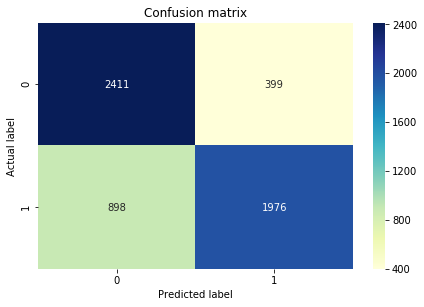

Accuracy: 0.7718156228008445
Precision: 0.832
Recall: 0.6875434933890049
F1 score: 0.7529053152981521


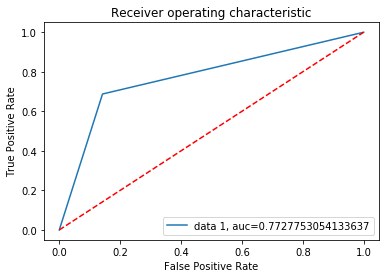

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

**Set of hyperparameters:  **

*     n_estimators = number of trees in the foreset
*     max_features = max number of features considered for splitting a node
*     max_depth = max number of levels in each decision tree
*     bootstrap = method for sampling data points (with or without replacement)

## 6.6.2 Boosting

# 6.6.2.1 GradientBoosting

A special case of boosting where errors are minimized by gradient descent algorithm e.g. the strategy consulting firms leverage by using case interviews to weed out less qualified candidates.

In [ ]:
learning_rate_ = [.01,.05,.1,.5,1]
n_estimators_ = [50,100,150,200,250,300]

param_grid = dict(learning_rate=learning_rate_, n_estimators=n_estimators_)

GB = GradientBoostingClassifier()

GB_GridSearch = GridSearch(X_train, y_train, GB, param_grid)
Prediction_GB = GB_GridSearch.Best_Model_Predict(X_test)

Best: 0.780469 using {'learning_rate': 0.05, 'n_estimators': 200}


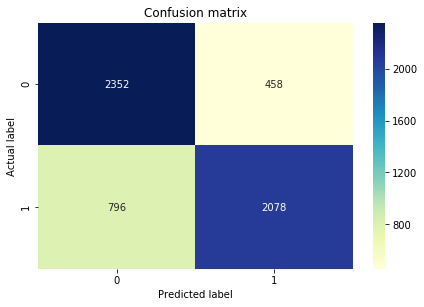

Accuracy: 0.7793807178043631
Precision: 0.8194006309148265
Recall: 0.7230340988169798
F1 score: 0.768207024029575


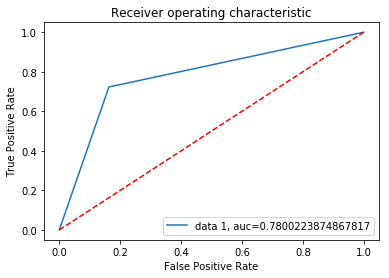

In [ ]:
cf_matrix = confusion_matrix(y_test, Prediction_GB)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print("Accuracy:",metrics.accuracy_score(y_test, Prediction_GB))
print("Precision:",metrics.precision_score(y_test, Prediction_GB))
print("Recall:",metrics.recall_score(y_test, Prediction_GB))
print("F1 score:",metrics.f1_score(y_test, Prediction_GB))

fpr, tpr, _ = metrics.roc_curve(y_test,  Prediction_GB)
auc = metrics.roc_auc_score(y_test, Prediction_GB)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()
#.712